## Data Collection and Preprocessing

- 수집으로부터 전처리, Tagging, Topic Modeling 등의 과정을 전체적으로 테스트하는 코드입니다.

In [2]:
import os
import sys
import re
import json
import time
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import praw

import google.generativeai as genai # Google Gemini API

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from datetime import datetime
from openai import OpenAI # OpenAI API
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation # LDA Topic Modeling

from tqdm.auto import tqdm

In [4]:
# environment setting

client_id = "" # reddit API
client_secret = ""  # reddit API
user_agent = "mr_xuan_" # reddit API

# API 설정
reddit = praw.Reddit(
    client_id = client_id,
    client_secret = client_secret,
    user_agent = user_agent
)

### Data Collection

수집 대상 : 노트북

In [9]:
# 🔍 특정 키워드의 전체 게시글 수 카운팅
# search_results = reddit.subreddit("laptops").search("macbook air m4", limit=None)
# search_results = reddit.subreddit("apple").search("macbook air m4", limit=None)
search_results = reddit.subreddit("laptops").hot(limit = 1000)

# 리스트로 변환하여 개수 확인
post_count = len(list(search_results))

print(f"--------------------------------------------------")
print(f"📊 검색 결과 분석")
print(f"📍 Subreddit : r/laptops")
print(f"📝 Total Posts : {post_count}개")
print(f"--------------------------------------------------") 

if post_count < 100:
    print("⚠️ 데이터가 너무 적습니다. 모델 변경이나 키워드 확장을 권장합니다.")
elif post_count >= 900:
    print("✅ 데이터가 충분하거나 API 한계치에 도달했습니다. 충분한 실험이 가능합니다.")

--------------------------------------------------
📊 검색 결과 분석
📍 Subreddit : r/laptops
📝 Total Posts : 1000개
--------------------------------------------------
✅ 데이터가 충분하거나 API 한계치에 도달했습니다. 충분한 실험이 가능합니다.


In [10]:
# 🔍 검색 결과 가져오기
# search_results = reddit.subreddit("apple").search("macbook air m4", limit=None)
search_results = reddit.subreddit("laptops").hot(limit = 100)

# 게시글별 댓글 수 리스트 생성
comment_counts = []
for submission in search_results:
    comment_counts.append({
        "Post_ID": submission.id,
        "Title": submission.title[:50] + "...",
        "Num_Comments": submission.num_comments
    })

# 데이터프레임 변환
count_df = pd.DataFrame(comment_counts)

# 📊 1. 기술 통계 요약
print("--------------------------------------------------")
print(f"📈 댓글 분포 통계 요약 (총 게시글 수: {len(count_df)}개)")
print(f"- 평균 댓글 수: {count_df['Num_Comments'].mean():.2f}개")
print(f"- 중앙값(Median): {count_df['Num_Comments'].median()}개")
print(f"- 최대 댓글 수: {count_df['Num_Comments'].max()}개")
print(f"- 댓글 0개인 게시글: {len(count_df[count_df['Num_Comments'] == 0])}개")
print("--------------------------------------------------")

# 📊 2. 상위 5개 댓글 부자 게시글 확인
print("\n🔥 댓글이 가장 많이 달린 TOP 5 게시글:")
print(count_df.sort_values(by='Num_Comments', ascending=False).head(5))

--------------------------------------------------
📈 댓글 분포 통계 요약 (총 게시글 수: 100개)
- 평균 댓글 수: 7.09개
- 중앙값(Median): 2.0개
- 최대 댓글 수: 193개
- 댓글 0개인 게시글: 34개
--------------------------------------------------

🔥 댓글이 가장 많이 달린 TOP 5 게시글:
    Post_ID                                              Title  Num_Comments
14  1qw5395       Good enough to play Terraria and YouTube?...           193
0    7eon9l  /r/SuggestALaptop's Official Discord - feel fr...           172
98  1qw581x  Just Looking For A Basic Laptop With Ethernet....            29
73  1qwkb6d                 Laptop (Probably doesn't exist)...            16
43  1qwiu9i                    what is the best laptop 2026...            13


In [12]:
# 데이터 수집 설정
target_subreddit = "laptops"
post_limit = 300
review_lst = []

print(f"🤖 [Data Collection] Reddit 크롤링을 시작합니다...")
print(f"--------------------------------------------------")
print(f"📍 Target Subreddit : {target_subreddit}")
print(f"📊 Post Limit       : {post_limit}")
print(f"--------------------------------------------------")

search_results = reddit.subreddit(target_subreddit).hot(limit = post_limit)

for submission in tqdm(search_results, total = post_limit, desc = "Collecting data"):
    # 게시글 정보 수집
    
    submission.comments.replace_more(limit=None)
    time.sleep(1.5) # 1.5초의 정지 -> 너무 많으면 429 Error가 나오기 때문

    # 제한 없이 모든 댓글 수집
    for comment in submission.comments.list():
        comment_info = {
            "Type": "Comment",
            "Body": comment.body,
            "Date": datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
            "URL": f"https://www.reddit.com{comment.permalink}"
        }
        review_lst.append(comment_info)

df = pd.DataFrame(review_lst)
print(f"\n✅ 수집 완료! 총 {df.shape[0]}개의 행이 저장되었습니다.")

# df.to_excel('./reddit_reviews.xlsx')

🤖 [Data Collection] Reddit 크롤링을 시작합니다...
--------------------------------------------------
📍 Target Subreddit : laptops
📊 Post Limit       : 300
--------------------------------------------------



✅ 수집 완료! 총 1971개의 행이 저장되었습니다.


In [3]:
# 테스트용

df = pd.read_excel('./reddit_reviews.xlsx')

In [4]:
df.shape

(2259, 5)

### NLP preprocessing

In [5]:
# 테스트 NLP Preprocessing

# Spacy 모델 로드 (품사 태깅 및 표제어 추출용)
# 설치 필요: python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

# 1. 기술 속성 구조화 함수 (기존 로직 유지)
def disambiguate_specs(text):
    text = text.lower()
    # 가격, 프레임, 해상도, 전력 등 수치 데이터의 의미론적 통합
    text = re.sub(r'\$(\d+)', r'price_\1', text)
    text = re.sub(r'\b(\d+)\s?(dollars|usd|bucks)\b', r'price_\1', text)
    text = re.sub(r'\b(\d{2,3})\s?(fps|hz)\b', r'fps_\1', text)
    text = re.sub(r'\b(\d{3,4})[pP]\b', r'res_\1p', text)
    text = re.sub(r'\b4[kK]\b', r'res_4k', text)
    text = re.sub(r'\b(\d+)\s?w\b', r'power_\1w', text)
    return text

# 2. 행위 중심(Activity-centric) 텍스트 정제 함수
def purpose_driven_clean(text):
    if not isinstance(text, str): return ""
    
    # A. 기본 노이즈 제거 및 스펙 단위 변환
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = text.replace('\n', ' ')
    text = disambiguate_specs(text)
    text = re.sub(r'[^a-z0-9_]', ' ', text) # 언더바(_) 보존
    
    # B. SpaCy를 이용한 정밀 분석
    doc = nlp(text)
    tokens = []
    
    # 목적 도출에 핵심적인 품사들만 선택 (명사, 동사, 형용사)
    # VERB를 포함함으로써 'playing', 'editing', 'working' 등 행위 정보를 포착
    allowed_postags = ['NOUN', 'VERB', 'ADJ']
    
    # 연구에서 '목적'을 정의하기 위해 반드시 살아있어야 하는 단어들 (기존 삭제 항목에서 제외)
    # 'game', 'play' 등이 살아있어야 'Gaming' 목적 군집이 형성됩니다.
    keep_for_purpose = {'game', 'play', 'use', 'work', 'study', 'edit', 'code', 'run'}
    
    for token in doc:
        # 불용어(Stopwords)이더라도 목적 관련 핵심어라면 통과
        is_purpose_keyword = token.text in keep_for_purpose
        
        if (is_purpose_keyword) or (not token.is_stop and token.pos_ in allowed_postags):
            # 표제어 추출 (Lemmatization)
            lemma = token.lemma_
            
            # 너무 짧은 단어 필터링 (숫자나 구조화된 스펙 제외)
            if len(lemma) > 2 or lemma.isdigit() or "_" in lemma:
                tokens.append(lemma)
    
    return " ".join(tokens)

# 3. 데이터프레임 적용 파이프라인
def preprocess_for_purpose_discovery(df):
    print("전처리 시작: 사용 목적(Purpose) 신호 강화 모드")
    
    # 원문이 삭제된 경우 제외
    df = df[~df['Body'].isin(['[deleted]', '[removed]'])].copy()
    
    # 전처리 적용 (tqdm으로 진행률 표시)
    tqdm.pandas()
    df['cleaned_Body'] = df['Body'].progress_apply(purpose_driven_clean)
    
    # 단어 수 기반 필터링 (정보량이 너무 적은 리뷰 제외)
    df['word_count'] = df['cleaned_Body'].apply(lambda x: len(str(x).split()))
    df = df[df['word_count'] >= 5] 
    
    print(f"전처리 완료. 최종 데이터 수: {len(df)}")
    return df

# 실행 예시
# _df_valid = preprocess_for_purpose_discovery(_df_raw)

In [6]:
print(f"정제 전 : {df.shape[0]}")
df = preprocess_for_purpose_discovery(df)

# df.to_excel('check_reddit_reviews.xlsx', index = False)

print(f"정제 후 : {df.shape[0]}")

정제 전 : 2259
전처리 시작: 사용 목적(Purpose) 신호 강화 모드


100%|██████████| 2252/2252 [00:07<00:00, 290.27it/s]

전처리 완료. 최종 데이터 수: 1486
정제 후 : 1486


### LLM-Tagging

In [ ]:
# 기본 세팅

GOOGLE_API_KEY = "" # Google Generative AI API Key
genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel(
    'gemini-2.5-flash-lite',
    generation_config={
        'response_mime_type' : 'application/json'
        }
)

OPENAI_API_KEY = "API KEY" # OpenAI API Key
client = OpenAI(api_key = OPENAI_API_KEY)

In [8]:
def get_openai_tags(review_text):
    # 시스템 프롬프트: 역할과 출력 형식을 강력하게 정의
    system_instruction = """
        ### Role: User Researcher for Multi-Purpose Product Analysis

        Your goal is to classify laptop reviews into specific "Usage Purpose" categories.
        
        ## Purpose Categories:

        1. Academic/Education: Focuses on school-related tasks, college life, note-taking, online learning, research, and general student productivity.
        2. Gaming/Hobby: Focuses on high-performance gaming, e-sports, hobbyist modding, and entertainment that requires high GPU/CPU performance.
        3. Professional: Focuses on "Work-critical" tasks including software development, data science, video editing, 3D rendering, graphic design, and corporate-level multi-tasking.
        4. Everyday/Casual: Focuses on light daily use, media consumption (Netflix/YouTube), social media, and web browsing without a specific professional or academic goal.
        
        ### Task: Analyze the provided laptop review and classify it.

        1. "is_valid" Check:
            - Set to "true" if the review contains meaningful feedback about the device.
            - Set to "false" ONLY if the review is spam, gibberish, or completely unrelated to laptop performance/experience.
        2. "purpose_classification":
            - Assign one or more categories from the list above.
            - Strict Rule: Only assign a specific category (1-4) if the review provides clear evidence of that use case.
        3. "evidence_snippet":
            - Quote the specific part of the review that indicates the assigned purpose. (e.g., "Great for rendering 4K video")

        ### Output Schema (JSON only):

        {
        "is_valid": boolean,
        "purpose_classification": ["string"],
        "evidence_snippet": "string",
        "reasoning": "string"
        }
    """

    user_prompt = f"""
        Review: "{review_text}"""
    
    try:
        response = client.chat.completions.create(
            model = "gpt-5.1",
            service_tier = "flex", # gpt 5.1의 flex를 사용하는 것을 명시적으로 반영
            messages = [
                {"role" : "system", "content" : system_instruction},
                {"role" : "user", "content" : user_prompt}
            ],
            temperature = 0,
            response_format = {'type' : 'json_object'}
        )

        return response.choices[0].message.content
    except Exception as e:
        print(f"Error : {e}")
        return None

In [9]:
# 실행 코드

print("Enhanced Tagging 시작... (사용자 성향 분석 중)")
results = []

for index, row in df.iterrows():
    json_str = get_openai_tags(row['cleaned_Body'])
    if json_str:
        try:
            data = json.loads(json_str)
            results.append(data)
        except json.JSONDecodeError:
            results.append({"is_valid" : False, "error" : "JSON Parse Error"})
    else:
        results.append({"is_valid" : False, "error" : "No Response"})
    
    time.sleep(1)

df_tag = pd.DataFrame(results)
df_tagged = pd.concat([df.reset_index(drop=True), df_tag], axis=1)

# df_tagged.to_excel('reddit_reviews_tagged.xlsx', index = False)

Enhanced Tagging 시작... (사용자 성향 분석 중)


In [10]:
df_tagged.to_excel('reddit_reviews_tagged_enhanced_without_category_5.xlsx', index = False)

In [27]:
df_tagged[df_tagged['is_valid'] == True]['purpose_classification'].value_counts()

purpose_classification
[General/Unspecified]                          50
[Creative/Pro]                                 35
[Office/Study]                                 25
[Gaming]                                       21
[Creative/Pro, Gaming]                          8
[Office/Study, General/Unspecified]             7
[Gaming, General/Unspecified]                   5
[Gaming, Office/Study]                          3
[Office/Study, Creative/Pro]                    2
[Office/Study, Gaming]                          2
[Gaming, Creative/Pro]                          2
[Creative/Pro, Office/Study]                    2
[Entertainment/Casual, Creative/Pro]            1
[Office/Study, Creative/Pro, Gaming]            1
[Office/Study, Entertainment/Casual]            1
[Entertainment/Casual, Office/Study]            1
[Entertainment/Casual, General/Unspecified]     1
Name: count, dtype: int64

In [12]:
for key in df_tagged[df_tagged['is_valid'] == True]['key_priority'].unique():
    print(f"{key} percentage : {df_tagged[df_tagged['key_priority'] == key].shape[0] / df_tagged[df_tagged['is_valid'] == True].shape[0] * 100:.2f}%")

Visuals percentage : 22.22%
Portability percentage : 9.15%
Performance percentage : 61.76%
Battery percentage : 3.59%
Comfort percentage : 1.31%
Price percentage : 1.96%


### Topic Modeling - LDA

In [13]:
# Topic Modeling

_df = df_tagged.copy()

_df_valid = _df[_df['is_valid'] == True] # True인 데이터만 가져오기

# 텍스트 전처리
_df_valid['cleaned_Body'] = _df_valid['cleaned_Body'].fillna('')
# _df_valid['key_priority'] = _df_valid['key_priority'].fillna('Unknown')

# Vectorization
# LDA의 경우 TF-IDF보다 CountVectorizer가 더 적합.
vectorizer = CountVectorizer(
    stop_words = 'english',
    max_features = 1000,
    ngram_range = (1, 2),
    max_df = 0.9,
    min_df = 2,
) # 기본 구성

/var/folders/cg/w5448dgs6vgg_kqyxn1mmxd80000gn/T/ipykernel_44255/26151985.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_valid['cleaned_Body'] = _df_valid['cleaned_Body'].fillna('')


Processing key_priority: Visuals
Processing key_priority: Portability
Processing key_priority: Performance
Processing key_priority: Battery
Processing key_priority: Comfort
Processing key_priority: Price


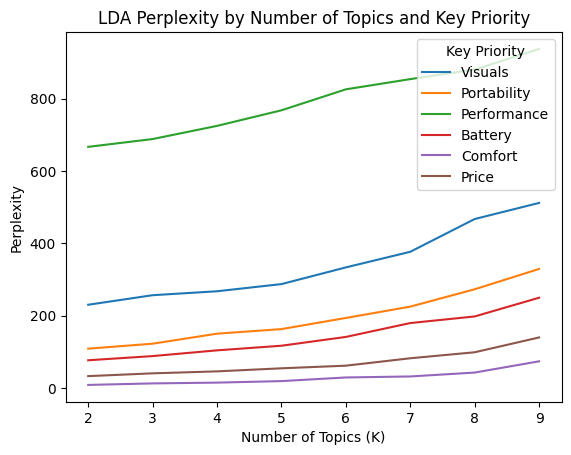

In [19]:
keys = _df_valid['key_priority'].unique()

# LDA Modeling

n_topics = 3 # 임시 -> 이후에 적절하게 결정을 해야 할 것 같다.
lda = LatentDirichletAllocation(
    n_components = n_topics,
    random_state = 42,
    max_iter = 10,
    learning_method = 'online',
    verbose = 1,
    n_jobs = -1,
)

# K valid
perplexity_values = []
k_range = range(2, 10)

for key in keys:
    print(f"Processing key_priority: {key}")
    dtm = vectorizer.fit_transform(_df_valid[_df_valid['key_priority'] == key]['cleaned_Body'])
    feature_names = vectorizer.get_feature_names_out()
    for k in k_range:
        lda = LatentDirichletAllocation(
            n_components = k,
            random_state = 42,
            max_iter = 10,
            learning_method = 'online',
            n_jobs = -1,
        )
        lda.fit(dtm)

        perp_val = lda.perplexity(dtm)
        perplexity_values.append((key, k, perp_val))

# 시각화
perplexity_df = pd.DataFrame(perplexity_values, columns = ['key_priority', 'n_topics', 'perplexity'])
sns.lineplot(data = perplexity_df, x = 'n_topics', y = 'perplexity', hue = 'key_priority')
plt.title('LDA Perplexity by Number of Topics and Key Priority')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Perplexity')
plt.legend(title = 'Key Priority')
plt.show()

In [ ]:
dtm = vectorizer.fit_transform(_df_valid['cleaned_Body'])
feature_names = vectorizer.get_feature_names_out()

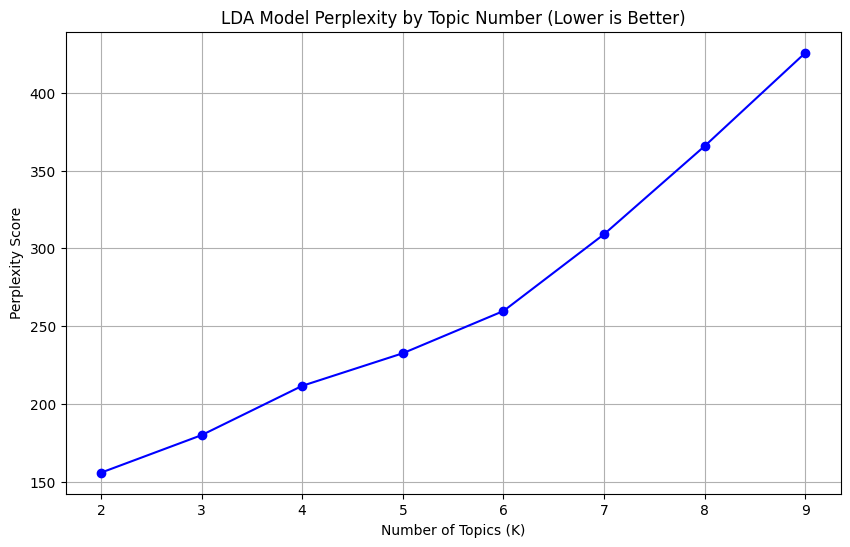

In [114]:
# LDA Modeling

n_topics = 3 # 임시 -> 이후에 적절하게 결정을 해야 할 것 같다.
lda = LatentDirichletAllocation(
    n_components = n_topics,
    random_state = 42,
    max_iter = 10,
    learning_method = 'online',
    verbose = 1,
    n_jobs = -1,
)

# K valid
perplexity_values = []
k_range = range(2, 10)

for k in k_range:
    lda = LatentDirichletAllocation(
        n_components = k,
        random_state = 42,
        max_iter = 10,
        learning_method = 'online',
        n_jobs = -1,
    )
    lda.fit(dtm)

    perp_val = lda.perplexity(dtm)
    perplexity_values.append(perp_val)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range, perplexity_values, marker='o', linestyle='-', color='b')
plt.title('LDA Model Perplexity by Topic Number (Lower is Better)')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.show()

In [20]:
# 주제별 토픽 모델링

for key in keys:
    print(f"Processing key_priority: {key}")
    dtm = vectorizer.fit_transform(_df_valid[_df_valid['key_priority'] == key]['cleaned_Body'])
    feature_names = vectorizer.get_feature_names_out()
    n_topics = 4 # 최종 결정
    lda = LatentDirichletAllocation(
        n_components = n_topics,
        random_state = 42,
        max_iter = 10,
        learning_method = 'online',
        verbose = 1,
        n_jobs = -1,
    )
    lda.fit(dtm)
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        top_features_indices = topic.argsort()[-10:][::-1]
        top_features = [feature_names[i] for i in top_features_indices]
        top_weights = topic[top_features_indices]
        for feature, weight in zip(top_features, top_weights):
            print(f"  {feature} ({weight:.2f})")
        print()

Processing key_priority: Visuals
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topic 1:
  switch (6.01)
  oled (4.48)
  looks (3.66)
  years (3.64)
  better (3.61)
  games (2.86)
  vrr (2.83)
  good (2.78)
  vita (2.72)
  ps (2.70)

Topic 2:
  deck (17.49)
  switch (15.06)
  better (8.68)
  steam deck (7.24)
  steam (7.18)
  handheld (6.86)
  1080p30 (4.45)
  runs (4.43)
  game (4.11)
  higher (4.07)

Topic 3:
  nintendo (19.33)
  like (13.55)
  switch (11.53)
  looks (11.09)
  just (10.66)
  people (9.16)
  screen (7.54)
  games (7.49)
  console (6.72)
  difference (5.74)

Topic 4:
  1080p (11.70)
  switch (10.78)
  mode (7.77)
  handheld (7.75)
  quality (7.50)
  dlss (7.02)
  resolution (6.02)
  performance (5.38)
  30 (4.43)
  1080p 30 (4.41

In [116]:
lda = LatentDirichletAllocation(
    n_components = n_topics,
    random_state = 42,
    max_iter = 10,
    learning_method = 'online',
    verbose = 1,
    n_jobs = -1,
)

lda.fit(dtm)

# 토픽별 핵심 키워드 및 해석 출력

print("\n=== 📊 LDA 토픽별 핵심 키워드 및 해석 ===")

for idx, topic in enumerate(lda.components_):
    print("\nTopic %d:" % (idx))
    
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]

    print(f"📌 Topic {idx}: {', '.join(top_features)}")    

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

=== 📊 LDA 토픽별 핵심 키워드 및 해석 ===

Topic 0:
📌 Topic 0: run, switch, 30, cyberpunk, 1080p, 2077, think, going, games, play

Topic 1:
📌 Topic 1: looks, steam, game, steam deck, deck, games, better, 60fps, bad, rough

Topic 2:
📌 Topic 2: looks, switch, good, handheld, pc, like, console, better, deck, game



=== 🔗 Topic vs Key Priority 매핑 (Cluster Definition) ===
key_priority    Battery  Comfort  Performance  Portability  Price  Visuals
Dominant_Topic                                                            
0                     0        0            8            0      0        1
1                     1        1           10            1      0        5
2                     1        0            7            3      1        9


C:\Users\108\AppData\Local\Temp\ipykernel_20220\2251698863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_valid['Dominant_Topic'] = topic_values.argmax(axis=1)


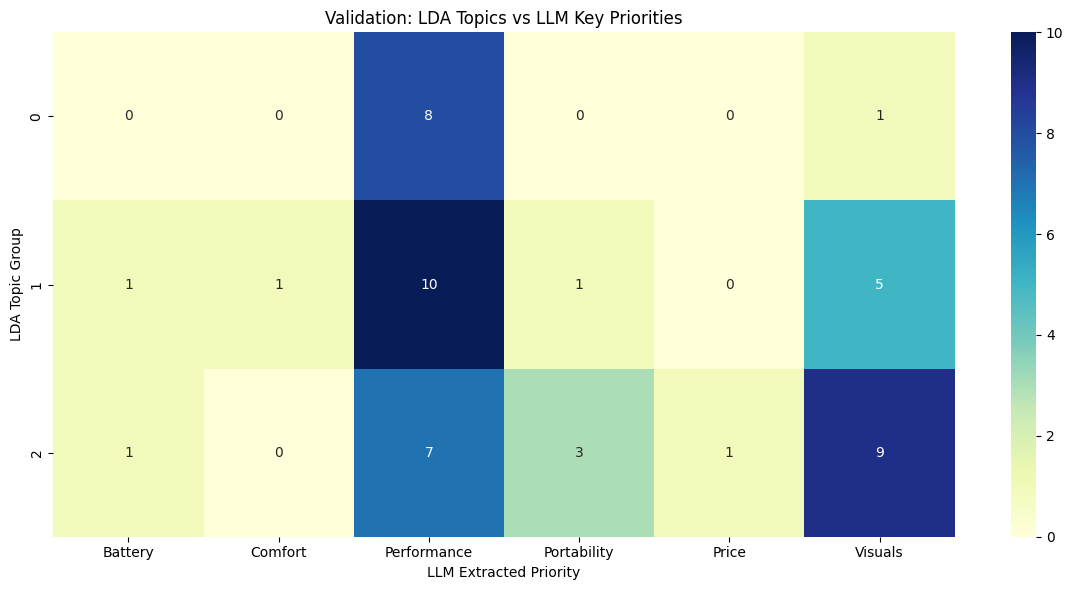

In [117]:
# 각 리뷰가 가장 높은 확률로 속하는 토픽 번호를 할당
topic_values = lda.transform(dtm)
_df_valid['Dominant_Topic'] = topic_values.argmax(axis=1)

# [핵심 과정] LLM Tag(Priority)와 LDA Topic 간의 관계 매핑
cross_tab = pd.crosstab(_df_valid['Dominant_Topic'], _df_valid['key_priority'])

print("\n=== 🔗 Topic vs Key Priority 매핑 (Cluster Definition) ===")
print(cross_tab)

# 시각화 (Heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Validation: LDA Topics vs LLM Key Priorities')
plt.ylabel('LDA Topic Group')
plt.xlabel('LLM Extracted Priority')
plt.tight_layout()
plt.show()

In [119]:
_df_valid

,Type,ID,Parent_ID,Author,User_ID,Body,Score,Date,URL,cleaned_Body,word_count,is_valid,key_priority,attributes,Dominant_Topic
0,Comment,mt9wbxh,t3_1kr1r4a,LongjumpingAd3493,t2_gtowt2szk,"This tag is wrong. Docked is 1080p 30-40, hand...",138,2025-05-20 19:52:02,https://www.reddit.com/r/consoles/comments/1kr...,"This tag is wrong. Docked is 1080p 30-40, hand...",17,True,Visuals,"[1080p, 720p]",0
2,Comment,mta7vdy,t3_1kr1r4a,goolerr,t2_1zwgv6hk,Pretty good considering it’s about the same ex...,13,2025-05-20 21:17:14,https://www.reddit.com/r/consoles/comments/1kr...,Pretty good considering it’s about the same ex...,32,True,Portability,"[handheld, form factor]",2
9,Comment,mt9x05l,t3_1kr1r4a,PugLove69,t2_19sr7hbk8w,It should have dynamic resolution like on pc a...,3,2025-05-20 19:57:30,https://www.reddit.com/r/consoles/comments/1kr...,It should have dynamic resolution like on pc a...,26,True,Performance,"[dynamic resolution, 60fps, 480p]",0
10,Comment,mta6fw9,t3_1kr1r4a,TerminaMoon,t2_xjb2j,"Not trying to knock the console, but are these...",3,2025-05-20 21:07:39,https://www.reddit.com/r/consoles/comments/1kr...,"Not trying to knock the console, but are these...",34,True,Performance,"[30fps, specs]",2
11,Comment,mta6g7t,t3_1kr1r4a,Dry-Dragonfruit-4382,t2_gartas7j,Kinda expected a bit more juice tbh. But it's ...,5,2025-05-20 21:07:43,https://www.reddit.com/r/consoles/comments/1kr...,Kinda expected a bit more juice tbh. But it's ...,28,True,Performance,[performance],2
12,Comment,mta5zwk,t3_1kr1r4a,vandridine,t2_78p79,"Unless this is your only console, it isn't wor...",2,2025-05-20 21:04:37,https://www.reddit.com/r/consoles/comments/1kr...,"Unless this is your only console, it isn't wor...",73,True,Performance,"[graphical fidelity, 720p]",1
13,Comment,mta6x88,t3_1kr1r4a,Randommer_Of_Inserts,t2_dzzz2b9g,This looks decent. I would personally never ge...,2,2025-05-20 21:10:54,https://www.reddit.com/r/consoles/comments/1kr...,This looks decent. I would personally never ge...,50,True,Portability,[optimised],2
14,Comment,mtb37mj,t3_1kr1r4a,inFINN1te,t2_15xqob,Too bad the battery will be dead within 2 hours.,2,2025-05-21 00:10:43,https://www.reddit.com/r/consoles/comments/1kr...,Too bad the battery will be dead within 2 hours.,10,True,Battery,[],1
17,Comment,mtbu16w,t3_1kr1r4a,Gytixas,t2_gdr5t,"It looks kind of good in some parts, but that ...",1,2025-05-21 02:21:05,https://www.reddit.com/r/consoles/comments/1kr...,"It looks kind of good in some parts, but that ...",49,True,Visuals,"[motion blur, upscaling]",2
18,Comment,mtc4wzw,t3_1kr1r4a,Ethereal-Throne,t2_5nq0ww6c,Barely playable for anyone who cares about exp...,1,2025-05-21 03:12:39,https://www.reddit.com/r/consoles/comments/1kr...,Barely playable for anyone who cares about exp...,19,True,Performance,[],2
